@swillner this is my attempt to see how OpenSCM's timeframes work from the user perspective. Let's use it as a discussion board.

When doing an interpolation there are choices to be made. I think the most common cases depend on three different things:

- whether you are doing interpolation only or also require extrapolation
    - for interpolation you have to think about what kind of spline you want to use (also depends on whether you need to preserve the integral or not)
    - for extrapolation you need to think about the kind of spline and how you extend it outside your data domain
- whether you are downscaling or upscaling
    - the spline you use may change depending on which way you're going (upscaling a moving average may be better, downscaling a spline may be better)
- whether you need to preserve the integral of your data or not
    - your spline will change depending on the answer

This gives us 8 possible outcomes (3 questions, 2 options per question). At the moment we are always assuming that we are in one of two cases: interpolation, integral preserving and down/upscaling. I think this is an error.

As a result, in OpenSCM I think we should have a default interpolation choice for each type of timeseries (emissions, concentrations, temperature etc.), this would be stored in some metadata attribute that would be defined as part of the OpenSCM standard. We should then give the user a way to override this default choice if they so wish. On top of this, I think we should have a notebook which illustrates each of the major cases and shows how it works in OpenSCM and how to override it.   

# Examples

The examples below go through a couple of the most common use cases for timeframes. I try to illustrate any assumptions and weaknesses of the OpenSCM approach as well as showing the impact of using different assumptions.

In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from itertools import count
from matplotlib import pyplot as plt
from copy import copy
from openscm import timeframes

<IPython.core.display.Javascript object>

In [2]:
COLOUR_1 = "lime"
COLOUR_2 = "midnightblue"
COLOUR_3 = "firebrick"
COLOUR_4 = "deeppink"

MARKER_1 = "o"
MARKER_2 = "^"
MARKER_3 = "+"
MARKER_4 = "x"

## Example 1: CO$_2$ Concentration Data

Consider a timeframe of 5 points representing, say, CO$_2$ concentration data.

In [3]:
# original CO2 conc data
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_time_period = 2
source_time_start = 1
source_times = np.linspace(
    source_time_start, 
    source_time_start + source_time_period*(len(source_values)-1), 
    len(source_values),
    dtype=int
) 

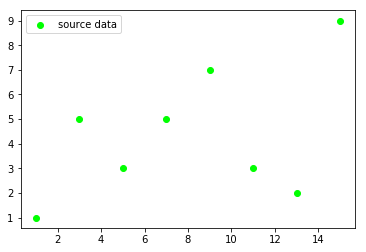

In [4]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.legend();

Now let's say that we want to interpolate this data onto a grid with a timestep which is half as small

In [5]:
target_times = np.linspace(
    source_times[0], 
    source_times[-1], 
    2*len(source_values) - 1,  # sit on end point exactly
    dtype=int
) 

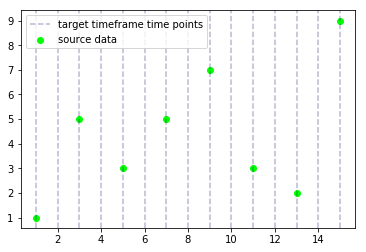

In [6]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color=COLOUR_2, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

In OpenSCM the default interpolation is a linear, integral preserving interpolation. For point data like this, this is probably not what we want (see below).

object of type <class 'float'> cannot be safely interpreted as an integer.


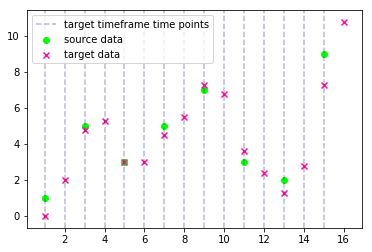

In [7]:
source = timeframes.Timeframe(
    start_time=source_time_start,
    period_length=source_time_period
)
target = timeframes.Timeframe(
    start_time=source_time_start,
    period_length=source_time_period*0.5
)
target_values_openscm = timeframes._convert(
    source_values,
    source,
    target
)
target_times_openscm = target.get_points(len(target_values_openscm))
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color=COLOUR_2, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.scatter(
    target_times_openscm, 
    target_values_openscm, 
    label="target data", 
    marker=MARKER_4, 
    color=COLOUR_4
)
ax.legend(loc="upper left");

The current integral preserving interpolation gives some very strange behaviour for a concentration timeseries. Firstly, you get this extra point at t=16 out of nowhere and secondly, the alteration of the first point in the series immediately looks wrong, as does the fact that the interpolated points don't all pass through the original points.

When interpolating point data like this, you most likely don't want to preserve the mean. In such a case, two approaches seem to be common:

1. linear interpolation
1. cubic splines

For more on splines and their pitfalls, in particular the pitfalls of the cubic spline, see [these resources](http://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2018/Lecture4.5_Splines.pdf) from the University of Copenhagen.

### Linear interpolation

This is very simple and allows you to generate a continous data set from the discrete points provided.

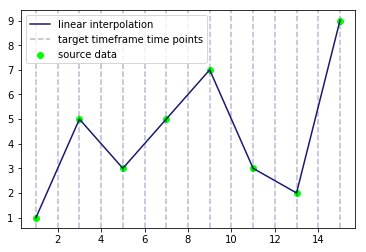

In [8]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.plot(
    source_times, 
    source_values, 
    label="linear interpolation", 
    marker=None, 
    color=COLOUR_2
)
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color=COLOUR_2, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

From the linearly interpolated data, we can simply calculate our target timeframe points.

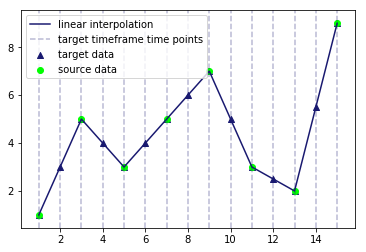

In [9]:
target_values = np.interp(target_times, source_times, source_values)
ax = plt.figure().add_subplot(111)
ax.plot(
    source_times, 
    source_values, 
    label="linear interpolation", 
    marker=None, 
    color=COLOUR_2
)
ax.scatter(
    target_times, 
    target_values, 
    label="target data", 
    marker=MARKER_2, 
    color=COLOUR_2
)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color=COLOUR_2, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

Removing our interpolation lines and target timeframe lines shows us the process from start to end.

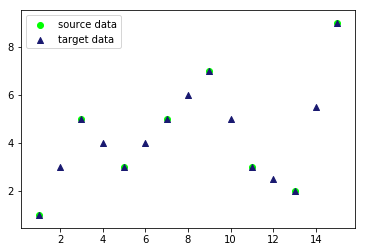

In [10]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.scatter(
    target_times, 
    target_values, 
    label="target data", 
    marker=MARKER_2, 
    color=COLOUR_2
)
ax.legend();

### Cubic spline interpolation

A cubic spline is often used as it results in a continuous first and second derivative over the entire range of the infilled function, something which is desirable for certain physical quantities (especially those which obey contiuity equations). 

In [11]:
cs = CubicSpline(source_times, source_values)
spline_times = np.linspace(
    source_times[0], 
    source_times[-1], 
    1000
)
spline_values = cs(spline_times)

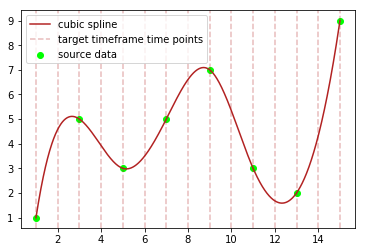

In [12]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.plot(
    spline_times, 
    spline_values, 
    label="cubic spline", 
    color=COLOUR_3
)
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color=COLOUR_3, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

The interpolated points are then

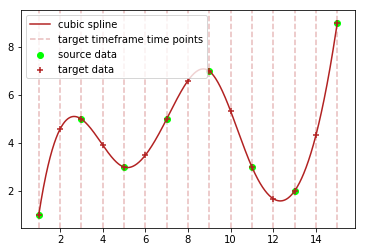

In [13]:
target_values_cubic_spline = cs(target_times)
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.plot(
    spline_times, 
    spline_values, 
    label="cubic spline", 
    color=COLOUR_3
)
ax.scatter(
    target_times, 
    target_values_cubic_spline, 
    label="target data", 
    marker=MARKER_3, 
    color=COLOUR_3
)
for i, x in enumerate(target_times):
    ax.axvline(
        x=x, 
        color=COLOUR_3, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

As we can see, these points are quite different from those inferred using a linear interpolation. Any data user has to think carefully about such choices.

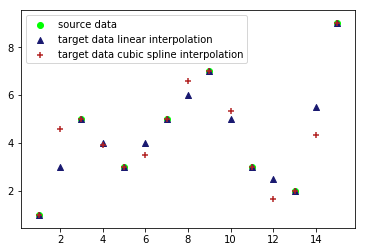

In [14]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.scatter(
    target_times, 
    target_values, 
    label="target data linear interpolation", 
    marker=MARKER_2, 
    color=COLOUR_2
)
ax.scatter(
    target_times, 
    target_values_cubic_spline, 
    label="target data cubic spline interpolation", 
    marker=MARKER_3, 
    color=COLOUR_3
)
ax.legend();

As a final wrap up, our linear and cubic spline interpolations are different again from OpenSCM's current behaviour. Accordingly, I think there is an argument that our current setup is overly limiting.

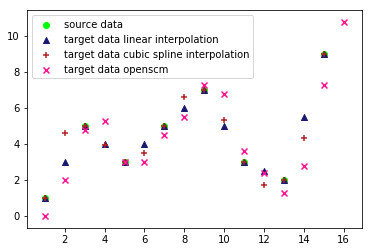

In [15]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.scatter(
    target_times, 
    target_values, 
    label="target data linear interpolation", 
    marker=MARKER_2, 
    color=COLOUR_2
)
ax.scatter(
    target_times, 
    target_values_cubic_spline, 
    label="target data cubic spline interpolation", 
    marker=MARKER_3, 
    color=COLOUR_3
)
ax.scatter(
    target_times_openscm, 
    target_values_openscm, 
    label="target data openscm", 
    marker=MARKER_4, 
    color=COLOUR_4
)
ax.legend();

## Example 2: Emissions data

In our second example we consider emissions data. As emissions are the flux of a material from one place (usually the Earth's surface) to somewhere else (normally the atmosphere), we have to make sure that the total amount of material is conserved during any interpolation. For flux variables, the total amount of material is represented by the integral of the flux timeseries and hence we need to preserve the integral when doing any interpolation.

Let's start with some emissions timeseries.

In [16]:
src_em_values = np.array([1, 4, 5, 2, 6, 7, 8, 5])
src_em_period = 2
src_em_start = 1
src_em_times = np.linspace(
    source_time_start, 
    source_time_start + source_time_period*(len(source_values)-1), 
    len(source_values),
    dtype=int
) 

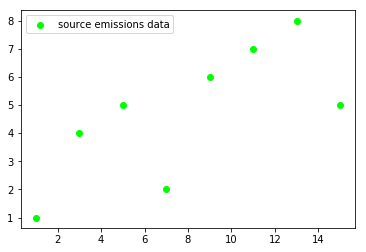

In [19]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    src_em_times, 
    src_em_values, 
    label="source emissions data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
ax.legend();

Once again, let's interpolate onto a grid with a timestep which is half as small.

In [20]:
tgt_em_times = np.linspace(
    src_em_times[0], 
    src_em_times[-1], 
    2*len(src_em_values) - 1,  # sit on end point exactly
    dtype=int
) 

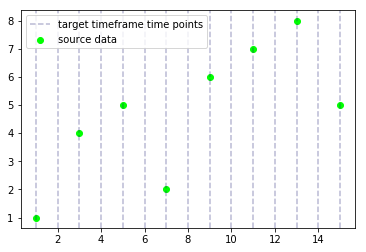

In [21]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    src_em_times, 
    src_em_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
for i, x in enumerate(tgt_em_times):
    ax.axvline(
        x=x, 
        color=COLOUR_2, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.legend(loc="upper left");

When doing an integral preserving interpolation from point data, the first question to answer is how to go from the source points to an integral. This requires some sort of spline and information about the time period each data point applies to. 

In OpenSCM the standard is that all points represent the average flux between their point in time and the next point in time in the timeseries and that the user must specify the time period (this makes it clear how long the last time point applies for). Hence when OpenSCM interpolates, it does a 'left-edge integral preserving interpolation'. Let's look at the result first, then unpack it.

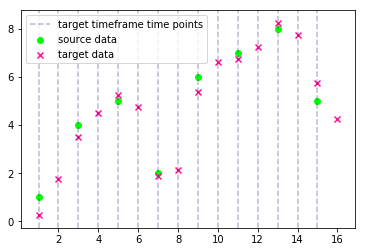

In [51]:
src_em = timeframes.Timeframe(
    start_time=src_em_start,
    period_length=src_em_period
)
tgt_em = timeframes.Timeframe(
    start_time=src_em_start,
    period_length=src_em_period*0.5
)
tgt_em_values_openscm = timeframes._convert(
    src_em_values,
    src_em,
    target
)
tgt_em_times_openscm = tgt_em.get_points(len(tgt_em_values_openscm))
ax = plt.figure().add_subplot(111)
ax.scatter(
    src_em_times, 
    src_em_values, 
    label="source data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
for i, x in enumerate(tgt_em_times):
    ax.axvline(
        x=x, 
        color=COLOUR_2, 
        alpha=0.3, 
        linestyle="--", 
        label="target timeframe time points" if i == 0 else None
    )
ax.scatter(
    tgt_em_times_openscm, 
    tgt_em_values_openscm, 
    label="target data", 
    marker=MARKER_4, 
    color=COLOUR_4
)
ax.legend(loc="upper left");

The first assumption in OpenSCM is that the source data is left edge, i.e. that the value applies to the entire timestep. A requirement in OpenSCM is that we define the time period, hence we know the period that the last data point applies to. The plot below should make this clearer.

In [52]:
def plot_timeframe_left_edge(ax, times, time_period, values, **kwargs):
    ax.step(
        np.concatenate([times, [times[-1] + time_period]]), 
        np.concatenate(([values[0]], values)), 
        **kwargs
    )

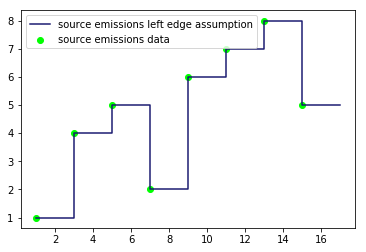

In [54]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    src_em_times, 
    src_em_values, 
    label="source emissions data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
plot_timeframe_left_edge(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions left edge assumption", 
    marker=None, 
    color=COLOUR_2,
)
ax.legend();

In the above we can see the 'left edge' assumption, i.e. that each time point applies to the entire timestep uniformly, and the use of the time period to extend the last data point over an entire time period (the 'left edge assumption' line does not stop at t=15, rather at t=17).

Other assumptions are possible, for example, 'centred' or 'right edge'.

In [62]:
def plot_timeframe_centred(ax, times, time_period, values, **kwargs):
    ax.step(
        np.concatenate([times, [times[-1] + time_period]]) - time_period / 2, 
        np.concatenate(([values[0]], values)), 
        **kwargs
    )

In [63]:
def plot_timeframe_right_edge(ax, times, time_period, values, **kwargs):
    ax.step(
        np.concatenate([[times[0] - time_period], times]), 
        np.concatenate(([values[0]], values)), 
        **kwargs
    )

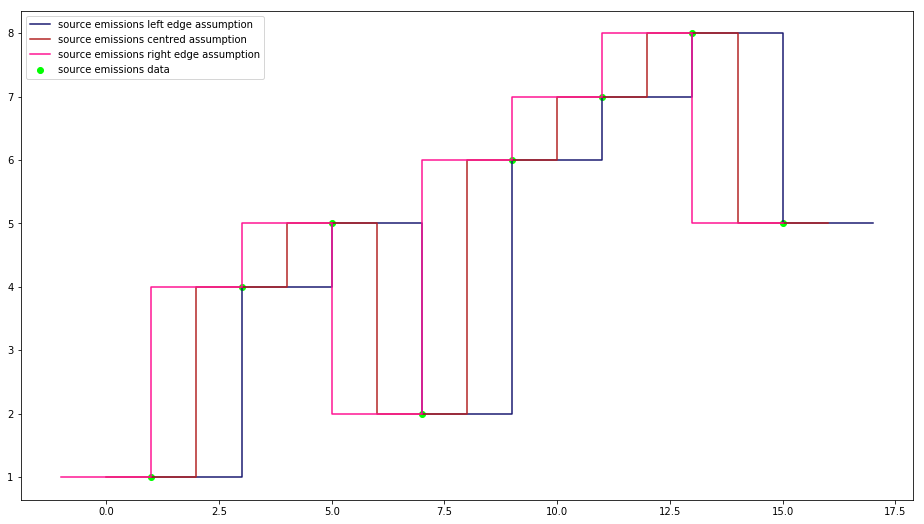

In [67]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
ax.scatter(
    src_em_times, 
    src_em_values, 
    label="source emissions data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
plot_timeframe_left_edge(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions left edge assumption", 
    marker=None, 
    color=COLOUR_2,
)
plot_timeframe_centred(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions centred assumption", 
    marker=None, 
    color=COLOUR_3,
)
plot_timeframe_right_edge(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions right edge assumption", 
    marker=None, 
    color=COLOUR_4,   
)
ax.legend();

Whilst these assumptions don't affect the shape of the 'infilled' data, they do affect the time period to which it applies and hence will affect any interpolation. To further complicate things, one could instead assume a linear spline between each of the points instead.

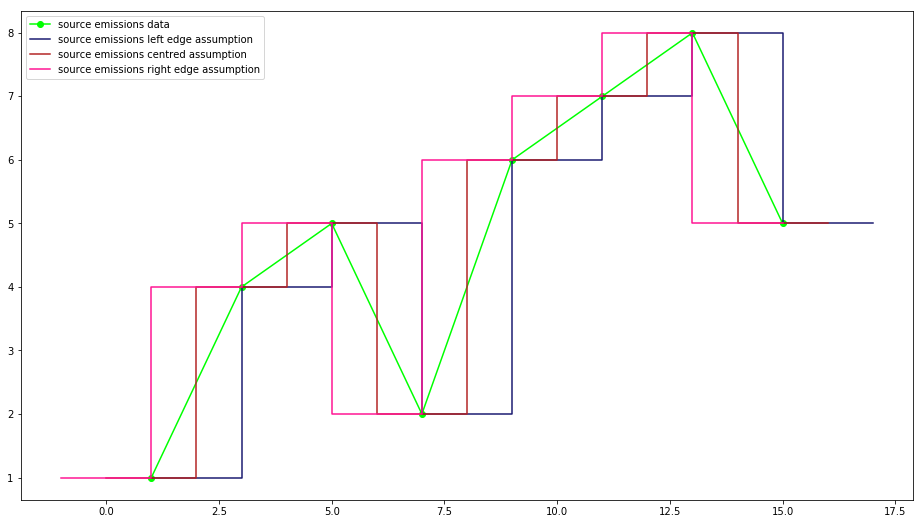

In [68]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
ax.plot(
    src_em_times, 
    src_em_values, 
    label="source emissions data", 
    marker=MARKER_1, 
    color=COLOUR_1
)
plot_timeframe_left_edge(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions left edge assumption", 
    marker=None, 
    color=COLOUR_2,
)
plot_timeframe_centred(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions centred assumption", 
    marker=None, 
    color=COLOUR_3,
)
plot_timeframe_right_edge(
    ax,
    src_em_times,
    src_em_period,
    src_em_values,
    label="source emissions right edge assumption", 
    marker=None, 
    color=COLOUR_4,   
)
ax.legend();

[TODO: integrate and then move back to points, showing that you have to use the same assumption to move back to points as you used to integrate otherwise things will go pear shaped if you later integrate again.]

resources

http://indico.hep.manchester.ac.uk/getFile.py/access?resId=0&materialId=slides&confId=4586

https://core.ac.uk/download/pdf/82383838.pdf